## Imports

In [868]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

sns.set_style('whitegrid')

## Load Data

# Best Random Forest

So Now we have identified best random Forest , lets see how its various performance are.

## Load Data

In [1048]:
data_all =  pd.read_csv('../processed_data/train_none_rf_impute' , index_col = 'obs_id').iloc[: , 1:]
#display(data_all)
np.random.seed(433)
data = data_all.sample(frac=1)
data_label = data['class']
x = data.copy()
brems_model = ['brems_nh' , 'brems_nh_lolim' , 'brems_nh_hilim' , 'brems_kt' , 'brems_kt_lolim' , 'brems_kt_hilim']
nh_params = ['bb_nh' , 'bb_nh_lolim' , 'bb_nh_hilim' , 'powlaw_nh' , 'powlaw_nh_lolim' , 'powlaw_nh_hilim']
inter_obs_param = ['var_inter_index' , 'var_inter_prob' , 'var_inter_sigma' , ]
x = x.drop(columns = inter_obs_param +brems_model + nh_params)
y = data_label.copy()
#data_all

## Train and save model

{'n_estimators': 222,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 85,
 'bootstrap': False}

In [1049]:
# Find and fit besst model
train_acc = []
test_acc = []
best_clf = ''
score = 0 
for i in tqdm(range(1)):
    rs = int(np.random.uniform(10 , 99999))
    #rs = 94968 # all feat
    rs = 92228 # removing nh only 
    #rs = 58987 # no model fit
    np.random.seed(rs)
    df =  x.sample(frac=1 , random_state=rs)
    y = df['class']
    x_train , x_test , _ , _ = train_test_split(df , y , test_size=0.2 , shuffle=True, random_state=10 , stratify=y)
    info_col = ['src_n' , 'src_id' , 'significance' , 'class']
    id_train = x_train[info_col]
    id_test = x_test[info_col]
    y_train = x_train['class']
    y_test = x_test['class']
    x_train = x_train.drop(info_col , axis=1)
    x_test = x_test.drop(info_col , axis = 1 )
    #np.random.seed(5926)
    clf = RandomForestClassifier(
        n_estimators= 222 , 
        criterion='entropy' ,
        random_state=12,
        max_depth=85 , 
        min_samples_leaf= 2 , 
        min_samples_split=2 , 
        bootstrap=False ,
        max_features='sqrt' ,
        class_weight='balanced'
        )
    clf.fit(x_train , y_train)
    tr = clf.score(x_train , y_train)
    next_score = clf.score(x_test , y_test)
    if(next_score > score):
        best_clf = clf
        score = next_score
        print('better found' , rs , next_score)
    #print(next_score , score)
    #print('\n -----------------')
    #print(rs , tst)
    ##train_acc.append(tr)
    #test_acc.append(tst)

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

better found 92228 0.9456521739130435


In [1050]:
test_score =  best_clf.score(x_test , y_test)
print(test_score)

0.9456521739130435


### Entropy-Wise Feature Importance

In [1051]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
#display(feat)
#feat.to_csv('result/feat_imp.csv')

## Bake Result

### Function

In [1052]:
def create_res_data(x , y , id_data  , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_bh = pred_prob[:,0]
    pred_prob_ns = pred_prob[:,1]
    pred_prob = [np.amax(pi) for pi in pred_prob]
    res =  x.copy()
    res = res[feat_names_sorted]
    #id_data = id_data.reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(1 , 'true_class' , y)
    res.insert(2 ,'pred_class' , pred)
    res.insert(3 , 'pred_prob' , pred_prob)
    res.insert(4 , 'BH_prob' , pred_prob_bh)
    res.insert(5 , 'NS_prob' , pred_prob_ns)
    res = pd.concat([id_data , res] , axis=1).drop('class' , axis=1)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.76):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    return res


### Bake it

In [1053]:

train_res = create_res_data(x_train , y_train ,id_train , cl_type='train')
test_res = create_res_data(x_test , y_test ,id_test , cl_type='test')
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')
res_data = pd.concat([train_res , test_res])
#res_data =  res_data.set_index('obs_id')
#res_data.to_csv('result/res_rf_tuned_rf_impute.csv')
#res_data

# Result Analysis

In [1054]:
data =  res_data.copy()
total = len(data)
print('Total samples' , total)
am_clf = len(data[data['th_class']=='X'])
print('Ambiguous calssification : ' , am_clf)
wrong_clf = len(data[data['truth']==0])
print('Wrong calssification : ' , wrong_clf)
print('Correct Classification :' , total - am_clf - wrong_clf)

Total samples 460
Ambiguous calssification :  23
Wrong calssification :  0
Correct Classification : 437


In [1055]:
data =  res_data.copy().query('clf_type=="test"')
total = len(data)
print('Total samples' , total)
am_clf = len(data[data['th_class']=='X'])
print('Ambiguous calssification : ' , am_clf)
wrong_clf = len(data[data['truth']==0])
print('Wrong calssification : ' , wrong_clf)
print('Correct Classification :' , total - am_clf - wrong_clf)
print('Accuracy : ' , ( total - am_clf - wrong_clf)/total)

Total samples 92
Ambiguous calssification :  19
Wrong calssification :  0
Correct Classification : 73
Accuracy :  0.7934782608695652


## ROC Curve

In [1056]:
res_data[res_data['truth']==0]

,src_n,src_id,significance,clf_type,true_class,th_class,is_ok,truth,pred_class,pred_prob,...,flux_bb_hilim,powlaw_ampl_lolim,flux_brems_hilim,flux_powlaw_hilim,flux_powlaw_lolim,flux_powlaw,flux_bb,brems_stat,powlaw_stat,flux_brems_lolim
obs_id,,,,,,,,,,,,,,,,,,,,,


In [1057]:
from sklearn.metrics import roc_curve , det_curve , roc_auc_score

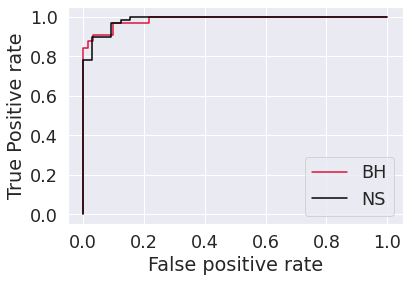

In [1058]:
res_data_tst = res_data.query('clf_type=="test"')
fpr , tpr , threshold = roc_curve(res_data_tst['true_class'] , res_data_tst['BH_prob'] , pos_label='BH' ,)
plt.plot(fpr , tpr ,  color = 'crimson' , label='BH' , )
fpr , tpr , threshold = roc_curve(res_data_tst['true_class'] , res_data_tst['NS_prob'] , pos_label='NS' , )
plt.plot(fpr , tpr , color = 'black' , label='NS' , )
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.savefig('result/plots/roc-auc-all.jpg')
plt.show()

In [1059]:
roc_auc = roc_auc_score(res_data_tst['true_class'] , res_data_tst['NS_prob'])
roc_auc

0.9854166666666666

## Feature Importance

multiplying the average standardised mean value of each feature split on each class, with the corresponding model._feature_importances array element. You can write a simple function that standardises your dataset, computes the mean of each feature split across class predictions, and does element-wise multiplication with the model._feature_importances array. The greater the absolute resulting values are, the more important the features will be to their predicted class, and better yet, the sign will tell you if it is small or large values that are important.

https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred/35255612

In [945]:
from sklearn.preprocessing import scale
import json
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        print(c)
        out[c] = dict(
            zip(range(M), (np.mean(X[Y==c, :], axis=0)*np.abs(feature_importances)))
        )
    return out


In [1029]:
feat_imp = best_clf.feature_importances_ 
result = class_feature_importance(x_train , y_train , feat_imp)


NS
BH


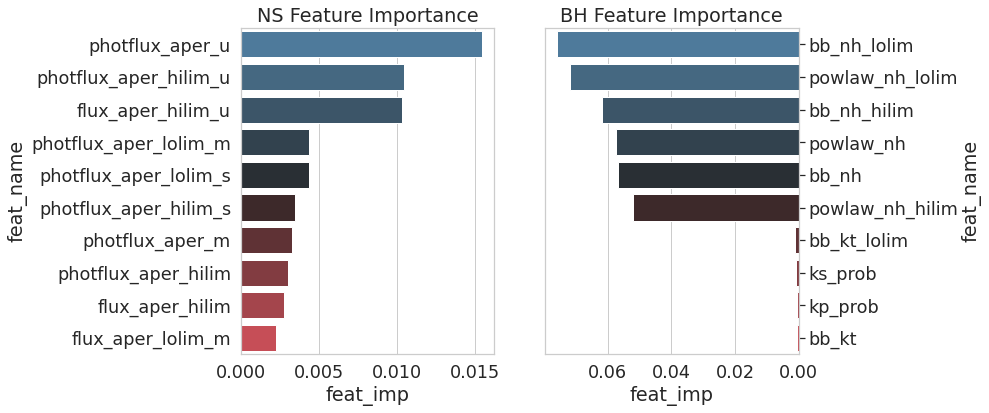

In [1030]:
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(10 ,6))
feat_names = x_train.columns.to_list()
top_feat = 10
#result['BH'].keys() = feat_names
values = list(result['NS'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_ns = df.copy()
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax1 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[0] )
values = list(result['BH'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_bh = df.copy()
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax2 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[1] )
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax1.set_title('NS Feature Importance')
ax2.set_title('BH Feature Importance')
plt.savefig('result/plots/feat-imp-all.jpg')
plt.show()

In [1031]:
values = list(result['NS'].values())
top_feat = 6 
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
for f in df.iloc[:top_feat,:]['feat_name']:
    print(f)

photflux_aper_u
photflux_aper_hilim_u
flux_aper_hilim_u
photflux_aper_lolim_m
photflux_aper_lolim_s
photflux_aper_hilim_s


## Imp features plot

In [884]:
rw_data = pd.concat(
    [pd.read_csv('../processed_data/BH_.csv' , index_col='obs_id') ,
    pd.read_csv('../processed_data/NS_.csv' , index_col='obs_id') ] , 
    axis=0
)
rw_data = rw_data.drop(columns=['index'])
rw_data
res_data_index =  res_data.index.tolist()
raw_data_sl = rw_data.loc[res_data_index]
#display(raw_data_sl)
res_data_id = res_data[['clf_type' , 'true_class'	,'th_class',	'is_ok',	'truth',	'pred_class',	'pred_prob']]
raw_data_sl = pd.concat([res_data_id , raw_data_sl ] , axis=1)
raw_data_sl 

,clf_type,true_class,th_class,is_ok,truth,pred_class,pred_prob,class,src_n,src_id,...,bb_ampl_lolim,bb_ampl_hilim,bb_stat,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
obs_id,,,,,,,,,,,,,,,,,,,,,
NS_OBS_392,train,NS,NS,1,1,NS,0.951057,NS,SAXWFC J1748.1-2446.,NS0071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_419,train,NS,NS,1,1,NS,0.931894,NS,1WGA J0748.5-6745,NS0076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_238,train,NS,NS,1,1,NS,0.987683,NS,XMMU J004245.2+41172,NS0044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BH_OBS_50,train,BH,BH,1,1,BH,0.941867,BH,CXOU J100510.0-07452,BH0016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_73,train,NS,NS,1,1,NS,0.988907,NS,3A 2129+470,NS0011,...,0.002624,0.005045,1.910,0.5730,0.6334,0.5150,33.92,37.80,30.57,1.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NS_OBS_426,test,NS,NS,1,1,NS,0.997038,NS,1WGA J1911.2+0035,NS0078,...,0.004665,0.009669,1.268,0.7198,0.8085,0.6393,39.67,44.48,35.32,1.023
BH_OBS_82,test,BH,BH,1,1,BH,0.955619,BH,CXOU J100516.2-07423,BH0020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_253,test,NS,NS,1,1,NS,0.994162,NS,XMMU J004245.2+41172,NS0046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


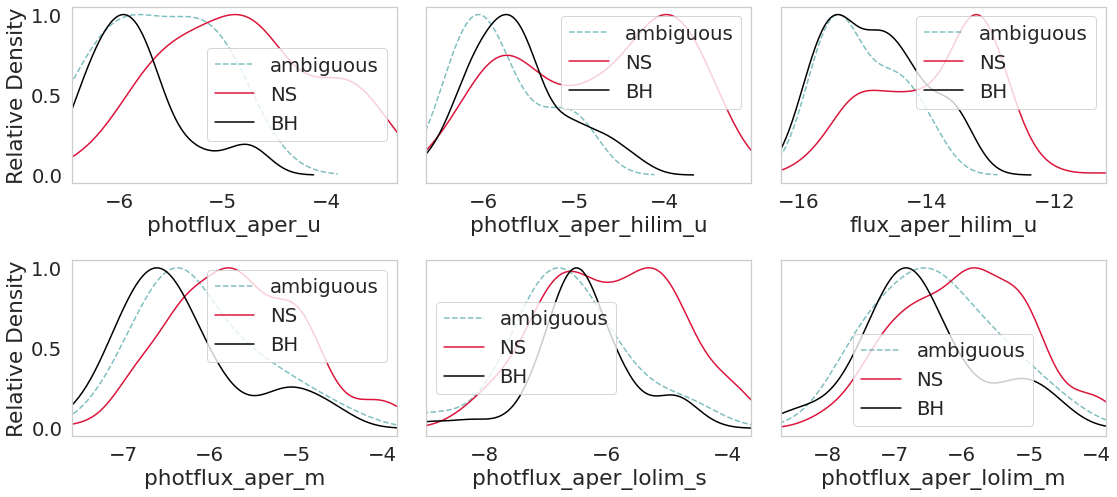

In [885]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_ns['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    #print(f)
    ax = sns.displot(data = raw_data_sl , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    index_col  =  raw_data_sl[raw_data_sl['th_class']=='X']
    ax2 = sns.displot(data = raw_data_sl[raw_data_sl['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'NS' , color='crimson')
    axi.plot(bh_x , bh , label = 'BH' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(raw_data_sl[f]) , np.amax(raw_data_sl[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
#fig.suptitle('Feature Distribution')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()


In [886]:
def is_outlier(points, thresh):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = np.asarray(points)
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation    
    return modified_z_score > thresh

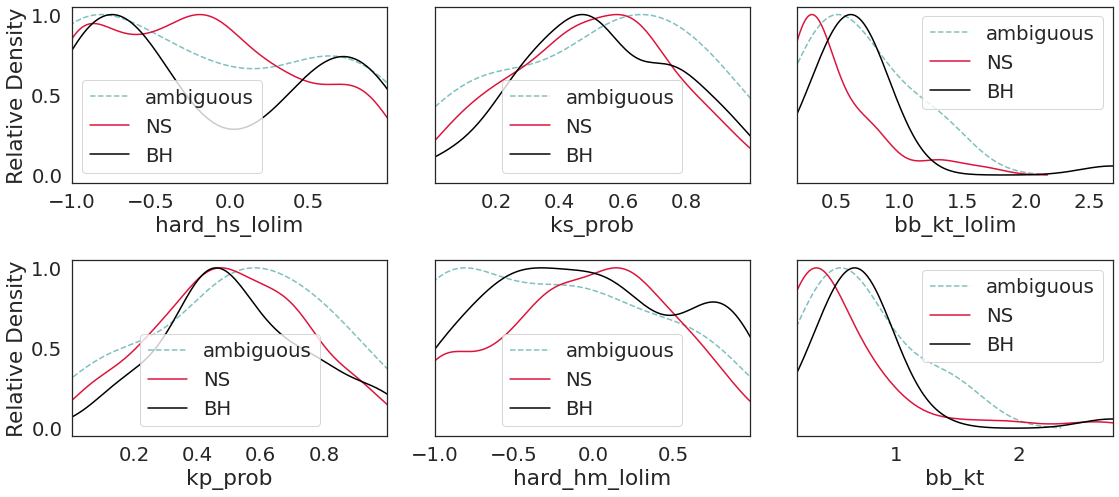

In [887]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_bh['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='powlaw_nh_hilim'):
        filtered_res = raw_data_sl[~is_outlier(raw_data_sl[f] , thresh=650)]
    else:
        filtered_res = raw_data_sl[~is_outlier(raw_data_sl[f] , thresh=350)]
    #filtered_res = raw_data_sl.copy()
    #print(f)
    ax = sns.displot(data = raw_data_sl , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = raw_data_sl[raw_data_sl['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'NS' , color='crimson')
    axi.plot(bh_x , bh , label = 'BH' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
#fig.suptitle('Feature Distribution')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()


In [888]:
display(res_data[res_data['true_class']=='NS']['th_class'].value_counts())
display(res_data[res_data['true_class']=='BH']['th_class'].value_counts())

NS    282
X      20
Name: th_class, dtype: int64

BH    152
X       6
Name: th_class, dtype: int64

## Probbaility Quality

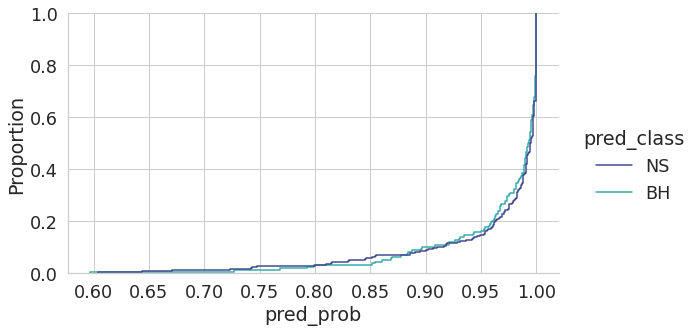

In [1032]:
res_data[[ 'th_class','pred_prob' , 'pred_class']]
sns.set_style('whitegrid')
sns.displot(
    data = res_data[[ 'th_class','pred_prob' , 'pred_class']] , 
    hue = 'pred_class' , 
    x = 'pred_prob' , 
    kind='ecdf' , 
    height= 5  , 
    aspect = 10/6 , 
    palette='mako'
)
plt.savefig('result/prob-quality-all.jpg')

## Prob feature correlation

In [890]:
used_cols = data_all.drop(['class' , 'src_id' , 'significance' , 'src_n'] , axis=1).columns.tolist()
raw_data_sl[used_cols]

,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_m,flux_aper_lolim_h,flux_aper_lolim_b,...,bb_ampl_lolim,bb_ampl_hilim,bb_stat,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
obs_id,,,,,,,,,,,,,,,,,,,,,
NS_OBS_392,-15.489723,-15.125982,-15.821311,-15.225848,-15.608536,-16.744969,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_419,NaN,NaN,-14.808829,NaN,-14.898253,NaN,NaN,-15.255942,NaN,-15.485585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_238,-14.175549,NaN,-14.325966,-14.004760,-13.718967,-14.330311,NaN,-14.498120,-14.226579,-13.819587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BH_OBS_50,-14.373968,-14.558148,-14.373557,-14.746662,-14.039815,-14.526075,-14.872247,-14.549597,-15.473661,-14.154778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_73,-13.209996,-14.401866,-13.325966,-13.246340,-12.798057,-13.248105,-14.607831,-13.377579,-13.359419,-12.829152,...,0.002624,0.005045,1.910,0.5730,0.6334,0.5150,33.92,37.80,30.57,1.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NS_OBS_426,-12.788079,-14.088363,-12.712870,-12.804931,-12.311580,-12.846795,-14.551448,-12.773142,-12.948076,-12.352421,...,0.004665,0.009669,1.268,0.7198,0.8085,0.6393,39.67,44.48,35.32,1.023
BH_OBS_82,-14.927750,-14.879755,-15.130710,-14.792096,-14.536555,-15.268976,-15.508218,-15.702896,-15.600153,-14.793984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NS_OBS_253,NaN,NaN,-14.936667,-13.997402,-14.010372,NaN,NaN,NaN,-14.932185,-14.945004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [891]:
res_data[[ 'th_class','pred_prob' , 'pred_class']]

,th_class,pred_prob,pred_class
obs_id,,,
NS_OBS_392,NS,0.951057,NS
NS_OBS_419,NS,0.931894,NS
NS_OBS_238,NS,0.987683,NS
BH_OBS_50,BH,0.941867,BH
NS_OBS_73,NS,0.988907,NS
...,...,...,...
NS_OBS_426,NS,0.997038,NS
BH_OBS_82,BH,0.955619,BH
NS_OBS_253,NS,0.994162,NS


In [892]:
df = pd.concat([res_data[['pred_prob' , 'th_class']] ,  raw_data_sl[used_cols] ] , axis=1)
df_ns = df[df['th_class']=='NS'].drop('th_class' , axis=1).corr().sort_values(by='pred_prob' , ascending=False)[['pred_prob']][1:]
df_bh = df[df['th_class']=='BH'].drop('th_class' , axis=1).corr().sort_values(by='pred_prob' , ascending=False)[['pred_prob']][1:]
df_bh.reset_index(inplace=True)
df_bh
df_ns.reset_index(inplace=True)


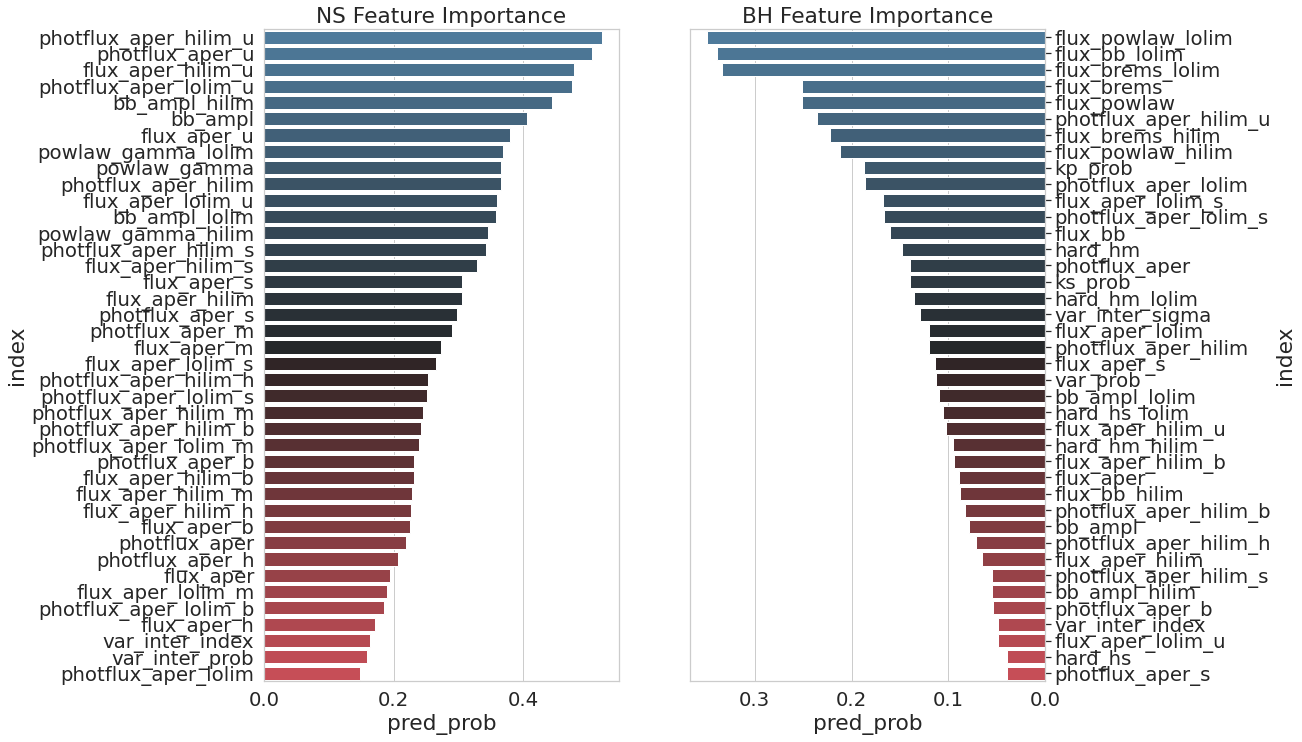

In [893]:
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(14 ,12))
top_feat = 40
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax1 = sns.barplot(data = df_ns.iloc[:top_feat,:] ,  x = 'pred_prob' , y = 'index'  ,palette = palette, ax=ax[0] )

palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax2 = sns.barplot(data = df_bh.iloc[:top_feat,:] , x = 'pred_prob' , y = 'index'  ,palette = palette, ax=ax[1] )

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax1.set_title('NS Feature Importance')
ax2.set_title('BH Feature Importance')
plt.show()

## Classwise Score

In [1060]:
#bh_sc = res_data.query('clf_type=="test" and true_class =="BH"')['truth'].value_counts()
bh_sc = res_data.query('True and true_class =="BH"')['truth'].value_counts()
ns_sc = res_data.query('True and true_class =="NS"')['truth'].value_counts()
display(bh_sc)
display(ns_sc)
cf = np.asarray([bh_sc[[1,2]].to_numpy() , ns_sc[[2 , 1]].to_numpy()]) 
cf 

1    152
2      6
Name: truth, dtype: int64

1    285
2     17
Name: truth, dtype: int64

array([[152,   6],
       [ 17, 285]])

In [1061]:
cf = np.asarray([
    [155 , 0 , 6] , 
    [0 , 285 , 17 ]
    ])

In [1062]:
cfp = np.asarray([[xi / sum(a) for xi in a] for a in cf])
cfp 

array([[0.96273292, 0.        , 0.03726708],
       [0.        , 0.94370861, 0.05629139]])

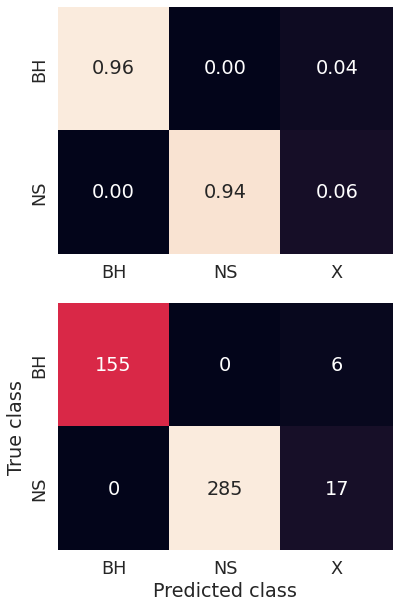

In [1063]:
sns.set(font_scale=1.6)
fig , ax = plt.subplots(nrows=2 , ncols=1 , figsize=(6,10))
sns.heatmap(cfp , annot=True , cbar=False , fmt='.02f' , ax=ax[0])
sns.heatmap(cf , annot=True , cbar=False , fmt='.0f' , ax=ax[1])
for a in ax:
    a.set_xticklabels(['BH' , 'NS' , 'X'])
    a.set_yticklabels(['BH' , 'NS'])
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.savefig('result/plots/cf-no-nh-all-train.jpg')
plt.show()

In [1037]:
#bh_sc = res_data.query('clf_type=="test" and true_class =="BH"')['truth'].value_counts()
bh_sc = res_data.query('clf_type=="test" and true_class =="BH"')['truth'].value_counts()
ns_sc = res_data.query('clf_type=="test" and true_class =="NS"')['truth'].value_counts()
display(bh_sc)
display(ns_sc)
cf = np.asarray([bh_sc[[1,2]].to_numpy() , ns_sc[[2 , 1]].to_numpy()]) 
cf 

1    29
2     3
Name: truth, dtype: int64

1    56
2     3
0     1
Name: truth, dtype: int64

array([[29,  3],
       [ 3, 56]])

In [1038]:
cf = np.asarray([
    [29 , 0 , 3] , 
    [1 , 56 , 3]
    ])
cfp = np.asarray([[xi / sum(a) for xi in a] for a in cf])
cfp 

array([[0.90625   , 0.        , 0.09375   ],
       [0.01666667, 0.93333333, 0.05      ]])

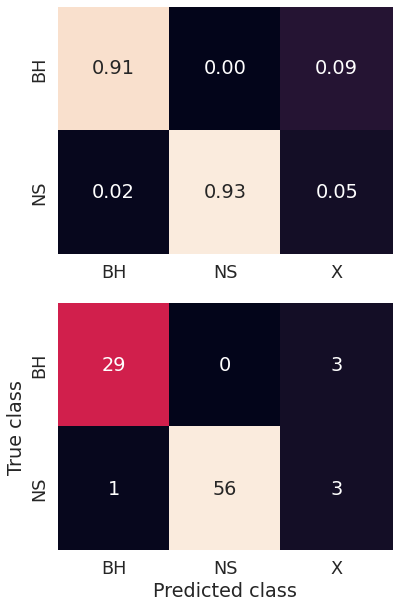

In [1039]:
sns.set(font_scale=1.6)
fig , ax = plt.subplots(nrows=2 , ncols=1 , figsize=(6,10))
sns.heatmap(cfp , annot=True , cbar=False , fmt='.02f' , ax=ax[0])
sns.heatmap(cf , annot=True , cbar=False , fmt='.0f' , ax=ax[1])
for a in ax:
    a.set_xticklabels(['BH' , 'NS' , 'X'])
    a.set_yticklabels(['BH' , 'NS'])
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.savefig('result/plots/cf-all-test.jpg')
plt.show()